# Ch05 Fractional Differentiation

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 

In [2]:
%load_ext autoreload
%autoreload 2

In [24]:
plt.style.use('seaborn-talk')
plt.style.use('bmh')
pd.set_option('display.max_rows', 100)


In [3]:
data = pd.read_parquet('/nfs/data/interim_2018/TRADE_A233740.parq')
data = data.set_index('TIMESTAMP')
data = data.loc[~data.index.duplicated()]

## FracDiff

In [4]:
def getWeights(d, size): 
    # thres > 0 drops insignificant weights 
    w = [1.]
    for k in range(1, size): 
        w_ = -w[-1] / k * (d - k + 1)
        w.append(w_)
        
    w = np.array(w[::-1]).reshape(-1, 1)
    return w


def fracDiff_(series, d, thres=.01):
    """
    Increasing width window, with treatment of NaNs
    Note 1: For thres=1, nothing is skipped.
    Note 2: d can be any positive fractional, not necessarily bounded [0,1].
    """
    #1) Compute weights for the longest series
    w = getWeights(d, series.shape[0])
    
    #2) Determine initial calcs to be skipped based on weight-loss threshold
    w_ = np.cumsum(abs(w))
    w_ /= w_[-1]
    skip = w_[w_>thres].shape[0]
    #3) Apply weights to values
    df = {}
    for name in series.columns:
        seriesF, df_ = series[[name]].fillna(method='ffill').dropna(), pd.Series()
        for iloc in range(skip, seriesF.shape[0]):
            loc = seriesF.index[iloc]
            if not np.isfinite(series.loc[loc,name]):
                continue # exclude NAs
            df_[loc] = np.dot(w[-(iloc+1):,:].T, seriesF.loc[:loc])[0,0]
        df[name] = df_.copy(deep=True)
    df = pd.concat(df, axis=1)
    return df



In [5]:
def plot_fd(df, fd, desc='fracdiff'): 
    fig, ax1 = plt.subplots(figsize=(18, 10))
    plt.title('FracDiff over the prices')
    ax1.plot(fd.index, df.loc[fd.index, 'close'], label = 'Raw prices', color='blue')
    
    ax2 = ax1.twinx()
    ax2.plot(fd.index, fd, color='red', label=desc)
    fig.figsizes = (18, 10)
    plt.legend()
    plt.show()

    
    

In [6]:
data0 = data.loc['2018-01-03', 'PRICE']
close0 = pd.DataFrame(data0)
close0.columns = ['close']


In [150]:
%%time
std_df = fracDiff(close0, 0.9, thres=1e-3)



CPU times: user 2min 2s, sys: 3min 45s, total: 5min 47s
Wall time: 52.8 s


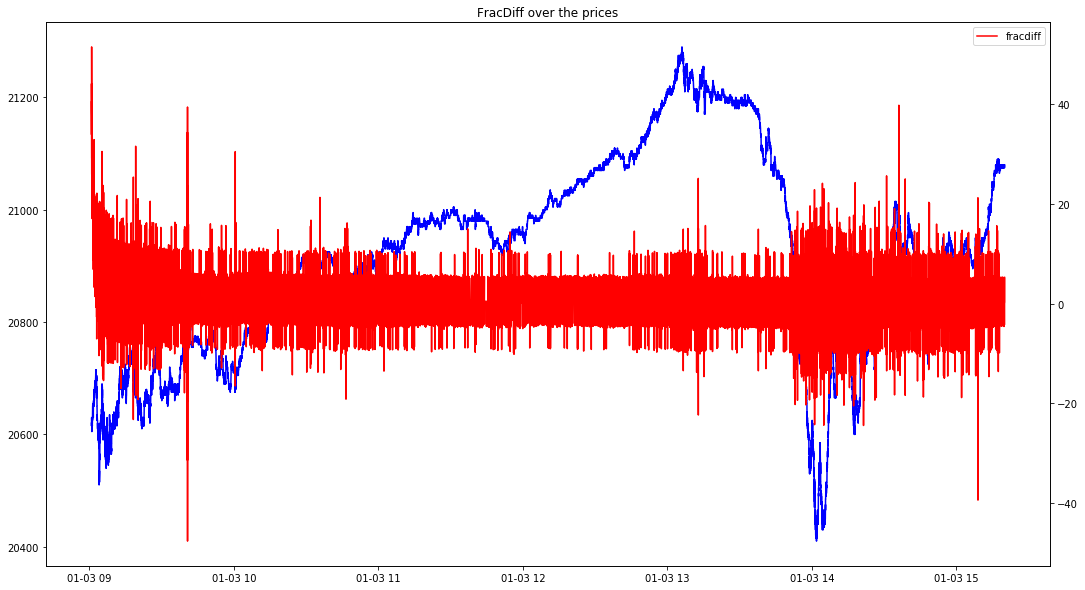

In [149]:
plot_fd(close0, std_df)

## FracDiff FFD 

In [11]:
def get_weights_ffd(d, thres, max_size=10_000):
    """
    Snippet 5.3 (page 83) The New Fixed-Width Window FracDiff Method

    :param d: int
    :param thres: float
    :param max_size: int, Set the maximum size for stability
    :return:
    """

    w = [1.]
    for k in range(1, max_size):
        w_ = -w[-1] / k * (d - k + 1)
        if abs(w_) <= thres:
            break

        w.append(w_)
    w = np.array(w)
    return w


def frac_diff_ffd(series, d, lag=1, thres=1e-5, max_size=10_000):
    """
    Snippet 5.3 (page 83) The New Fixed-Width Window FracDiff Method

    Compute Fractional Differentiation

    :param series:
    :param d:
    :param lag:
    :param thres:
    :param max_size:
    :return:
    """

    max_size = int(max_size / lag)
    w = get_weights_ffd(d, thres, max_size)
    width = len(w)
    series_ = series.fillna(method='ffill').dropna()
    rolling_array = []
    for i in range(width):
        rolling_array.append(series_.shift(i * lag).values)

    rolling_array = np.array(rolling_array)
    series_val = np.dot(rolling_array.T, w)    
    series_val = series_val.reshape(-1, )
    timestamps = series.index[-len(series_val):]
    series = pd.Series(series_val, index=timestamps)
    return series


In [20]:
%%time
frac_df_09 = frac_diff_ffd(close0['close'], 0.9, thres=1e-3)


CPU times: user 4.95 ms, sys: 741 µs, total: 5.7 ms
Wall time: 2.95 ms


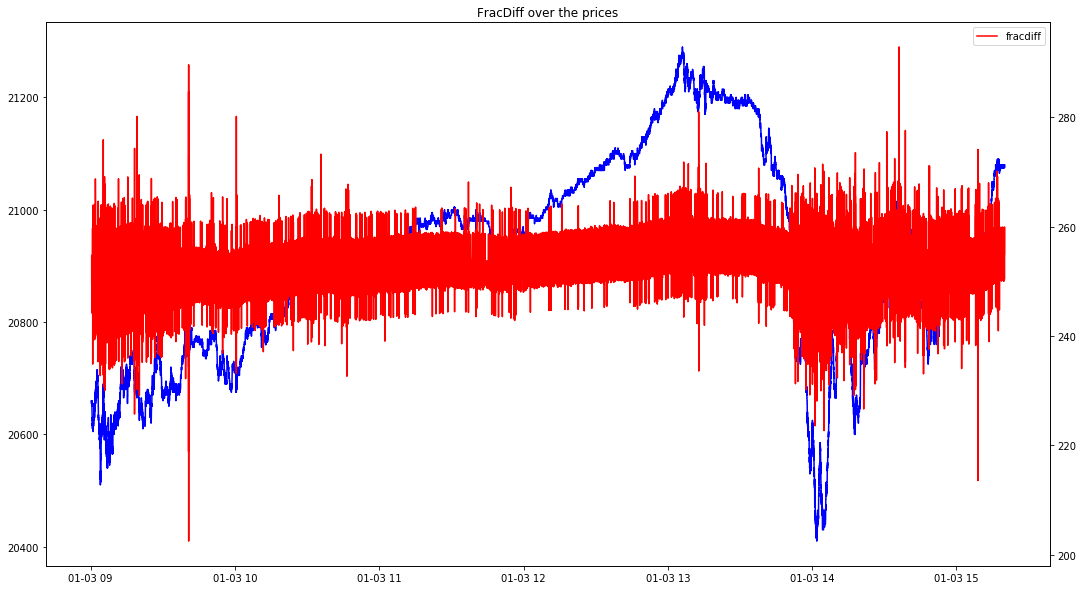

In [21]:
plot_fd(close0, frac_df_09)

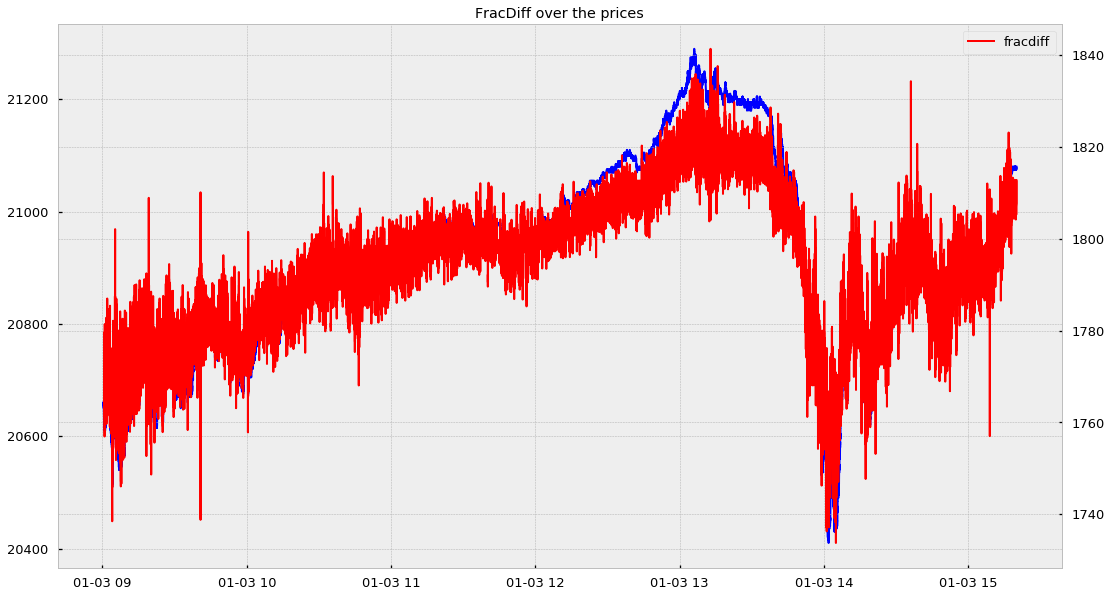

CPU times: user 766 ms, sys: 862 ms, total: 1.63 s
Wall time: 504 ms


In [26]:
%%time
frac_df_05 = frac_diff_ffd(close0['close'], 0.5, thres=1e-3)
plot_fd(close0, frac_df_05)

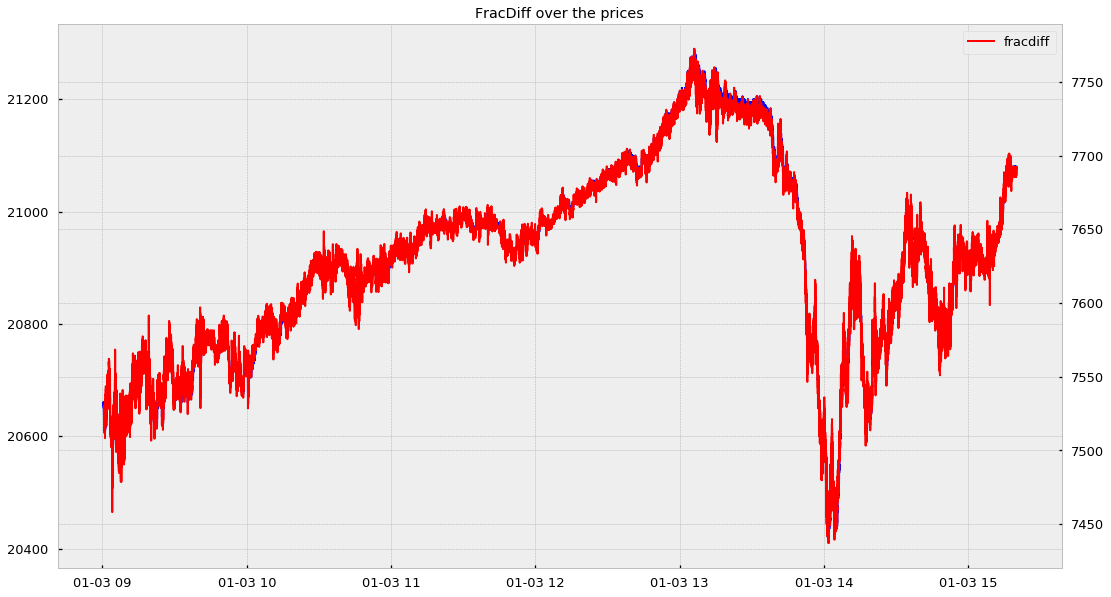

CPU times: user 714 ms, sys: 853 ms, total: 1.57 s
Wall time: 439 ms


In [27]:
%%time
frac_df_02 = frac_diff_ffd(close0['close'], 0.2, thres=1e-3)
plot_fd(close0, frac_df_02)

# APPENDIX